### Yfaince回測模型

[*********************100%***********************]  1 of 1 completed



Index 20 (Date: 2024-12-31 00:00:00):
  Window Start Date: 2024-12-03 00:00:00
  ARIMA Parameters: p=0, d=0, q=1
  RMSE: 0.006669, MAE: 0.005570
  Predicted Dates: DatetimeIndex(['2024-12-31', '2025-01-01', '2025-01-02'], dtype='datetime64[ns]', freq='B')
  Predictions vs Actuals:
    Day 1 (2024-12-31 00:00:00): Predicted=-0.004091, Actual=-0.004500
    Day 2 (2025-01-01 00:00:00): Predicted=0.000000, Actual=0.007700
    Day 3 (2025-01-02 00:00:00): Predicted=0.000000, Actual=0.008600

Index 23 (Date: 2025-01-03 00:00:00):
  Window Start Date: 2024-12-06 00:00:00
  ARIMA Parameters: p=0, d=0, q=1
  RMSE: 0.006579, MAE: 0.005034
  Predicted Dates: DatetimeIndex(['2025-01-03', '2025-01-06', '2025-01-07'], dtype='datetime64[ns]', freq='B')
  Predictions vs Actuals:
    Day 1 (2025-01-03 00:00:00): Predicted=0.002401, Actual=-0.008600
    Day 2 (2025-01-06 00:00:00): Predicted=0.000000, Actual=0.001600
    Day 3 (2025-01-07 00:00:00): Predicted=0.000000, Actual=0.002500

Index 26 (Date: 

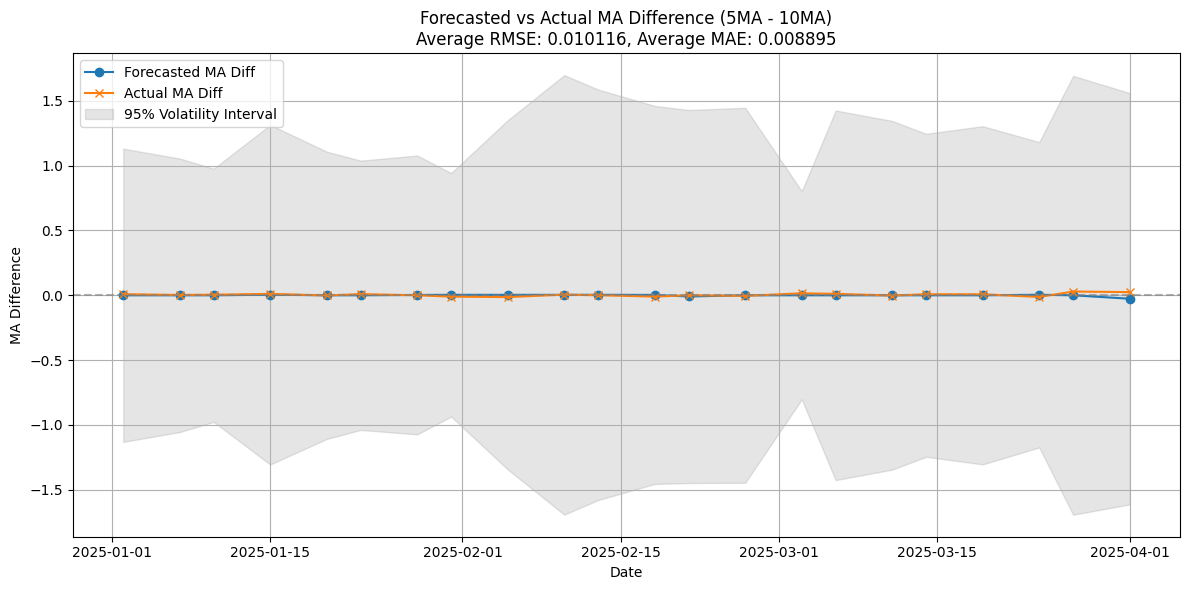

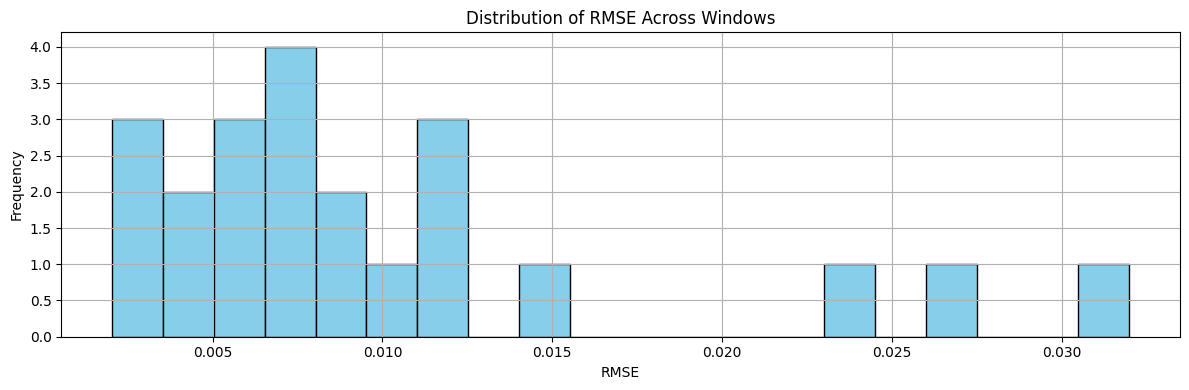

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from arch import arch_model
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_data(ticker='00708L.TW', start_date='2023-12-01', end_date=datetime.today().strftime('%Y-%m-%d')):
    """
    下載歷史資料，設置交易日索引，計算移動平均線和 ma_diff。
    返回處理好的 DataFrame。
    """
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d', auto_adjust=True)
    df = data[["Close"]].dropna()
    
    trading_days = pd.date_range(start=df.index[0], end=df.index[-1], freq='B')
    trading_days = trading_days[:len(df)]
    df.index = trading_days
    
    df["ema_short"] = df["Close"].ewm(span=5, adjust=False).mean()  # 5EMA
    df["ema_long"] = df["Close"].ewm(span=10, adjust=False).mean()  # 10EMA
    df["diff"] = df["ema_short"] - df["ema_long"]
    df.dropna(inplace=True)
    
    return df

def rolling_ma_arima_garch_forecast(df, window_size=20, forecast_horizon=3, step=5, plot=True):
    """
    執行 auto_arima+GARCH 預測，使用 20 天窗口預測未來三天，整合 GARCH 波動性，
    計算預測準確度並評估模型性能，增強日誌輸出。
    Args:
        df: 包含 ma_diff 的 DataFrame
        window_size: 訓練窗口大小（預設 20 天）
        forecast_horizon: 預測步數（預設 3 天）
        step: 每次迴圈的步長
        plot: 是否繪製圖表
    Returns:
        forecast_df: 包含預測、實際值、誤差和波動性的 DataFrame
        df: 原始 DataFrame
    """
    ma_diff = df["diff"]
    dates = df.index
    
    forecasts = []
    actuals = []
    forecast_dates = []
    rmses = []
    maes = []
    volatilities = []

    for i in range(window_size, len(ma_diff) - forecast_horizon + 1, step):
        train = ma_diff[i - window_size:i]
        test = ma_diff[i:i + forecast_horizon]

        # 檢查資料異常
        if train.std() < 1e-6 or train.isna().any() or len(test) < forecast_horizon:
            print(f"Warning: Invalid data at index {i} (Date: {dates[i]}). Skipping.")
            continue

        try:
            # 使用 auto_arima 自動選擇 p, d, q
            arima_model = auto_arima(
                train,
                max_p=2,
                max_d=1,
                max_q=2,
                seasonal=False,
                suppress_warnings=True,
                error_action='ignore',
                stepwise=True
            )
            arima_resid = arima_model.arima_res_.resid

            # GARCH 模型
            scaled_resid = arima_resid * 10
            garch_model = arch_model(scaled_resid, vol='Garch', p=1, q=1, rescale=False)
            garch_fit = garch_model.fit(disp='off')

            # ARIMA 預測未來三天
            arima_forecast = arima_model.predict(n_periods=forecast_horizon)
            
            # GARCH 預測未來三天的波動性
            garch_forecast = garch_fit.forecast(horizon=forecast_horizon)
            volatility = np.sqrt(garch_forecast.variance.values[-1, :]) / 10  # 反縮放並取平方根

            # 計算預測值和實際值的誤差
            forecasted_diff = arima_forecast / 100  # ARIMA 預測值
            actual_diff = test / 100  # 實際值
            rmse = np.sqrt(mean_squared_error(actual_diff, forecasted_diff))
            mae = mean_absolute_error(actual_diff, forecasted_diff)

            # 儲存結果
            forecasts.append(forecasted_diff.values)
            actuals.append(actual_diff.values)
            rmses.append(rmse)
            maes.append(mae)
            volatilities.append(volatility)
            forecast_dates.append(dates[i + forecast_horizon - 1])

            # 增強日誌輸出
            p, d, q = arima_model.order
            start_date = dates[i - window_size]
            pred_dates = dates[i:i + forecast_horizon]
            print(f"\nIndex {i} (Date: {dates[i]}):")
            print(f"  Window Start Date: {start_date}")
            print(f"  ARIMA Parameters: p={p}, d={d}, q={q}")
            print(f"  RMSE: {rmse:.6f}, MAE: {mae:.6f}")
            print(f"  Predicted Dates: {pred_dates}")
            print("  Predictions vs Actuals:")
            for j, (pred, act, date) in enumerate(zip(forecasted_diff, actual_diff, pred_dates)):
                print(f"    Day {j+1} ({date}): Predicted={pred:.6f}, Actual={act:.6f}")

        except Exception as e:
            print(f"Error at index {i} (Date: {dates[i]}): auto_arima/GARCH failed, Error: {e}")
            continue

    # 建立結果 DataFrame
    forecast_df = pd.DataFrame({
        'Forecasted_MA_Diff': [f[-1] for f in forecasts],  # 取三天預測的最後一天
        'Actual_MA_Diff': [a[-1] for a in actuals],  # 取三天實際的最後一天
        'RMSE': rmses,
        'MAE': maes,
        'Volatility': [v[-1] for v in volatilities]  # 取三天波動性的最後一天
    }, index=forecast_dates)

    if plot:
        # 計算整體評估指標
        overall_rmse = np.mean(rmses) if rmses else np.nan
        overall_mae = np.mean(maes) if maes else np.nan
        print(f"\nOverall Model Performance:")
        print(f"Average RMSE: {overall_rmse:.6f}")
        print(f"Average MAE: {overall_mae:.6f}")

        # 繪圖：預測 vs 實際（含波動性區間）
        plt.figure(figsize=(12, 6))
        plt.plot(forecast_df.index, forecast_df['Forecasted_MA_Diff'], label='Forecasted MA Diff', marker='o')
        plt.plot(forecast_df.index, forecast_df['Actual_MA_Diff'], label='Actual MA Diff', marker='x')

        # 繪製 GARCH 波動性區間（95% 信心區間）
        upper_bound = forecast_df['Forecasted_MA_Diff'] + 1.96 * forecast_df['Volatility']
        lower_bound = forecast_df['Forecasted_MA_Diff'] - 1.96 * forecast_df['Volatility']
        plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Volatility Interval')

        plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
        plt.title(f'Forecasted vs Actual MA Difference (5MA - 10MA)\nAverage RMSE: {overall_rmse:.6f}, Average MAE: {overall_mae:.6f}')
        plt.xlabel('Date')
        plt.ylabel('MA Difference')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 繪製誤差分佈圖
        plt.figure(figsize=(12, 4))
        plt.hist(rmses, bins=20, color='skyblue', edgecolor='black')
        plt.title('Distribution of RMSE Across Windows')
        plt.xlabel('RMSE')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return forecast_df, df

# 執行函數
df = get_data()
forecast_df, df = rolling_ma_arima_garch_forecast(df, window_size=20, forecast_horizon=3, step=3)

### Yfiance預測N天

[*********************100%***********************]  1 of 1 completed



2025-04-22 00:00:00 的預測結果：
  ARIMA 參數：p=1, d=1, q=0
  VWAP（當前）：56.64, Close（當前）：64.75
  預測 VWAP、波動性範圍、2倍標準差範圍和交易訊號：
    2025-04-23 00:00:00: VWAP=57.90, Volatility Range=[57.58, 58.21], 2STD Range=[51.45, 64.34], Signal=賣出
    2025-04-24 00:00:00: VWAP=58.96, Volatility Range=[58.65, 59.28], 2STD Range=[52.52, 65.41], Signal=持有
    2025-04-25 00:00:00: VWAP=59.89, Volatility Range=[59.57, 60.20], 2STD Range=[53.44, 66.33], Signal=持有
開始生成圖表...


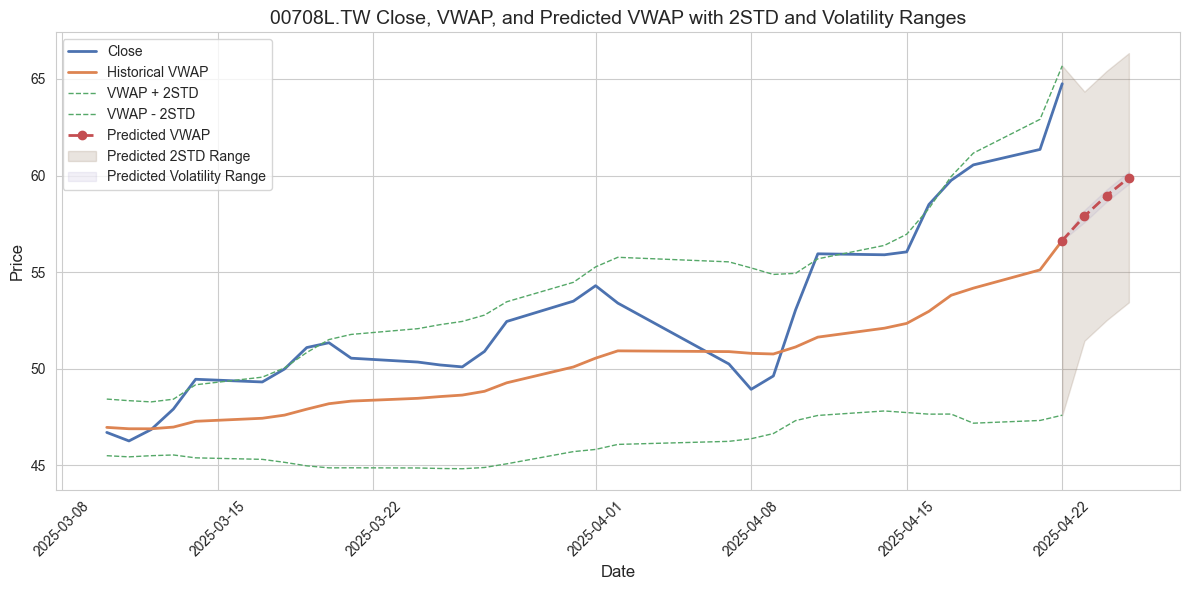

圖表生成完成


In [61]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from arch import arch_model
from datetime import datetime, timedelta

def get_data(ticker='00708L.TW', end_date=datetime.today().strftime('%Y-%m-%d'), window_size=20, plot_days=30):
    """
    下載歷史資料，計算滾動 VWAP 及其時間窗口內的 2 倍標準差上下軌。
    """
    # 處理 end_date 的類型
    if isinstance(end_date, str):
        end_date = pd.to_datetime(end_date)
    elif isinstance(end_date, (datetime, pd.Timestamp)):
        end_date = pd.to_datetime(end_date)
    else:
        raise ValueError(f"end_date 必須是字串、datetime 或 pandas Timestamp，得到 {type(end_date)}")

    today = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))
    if end_date > today:
        print(f"警告: end_date {end_date} 是未來日期，使用今日日期 {today}")
        end_date = today

    buffer_days = int(max(window_size, plot_days) * 2)
    start_date = end_date - timedelta(days=buffer_days)

    try:
        data = yf.download(ticker, start=start_date, end=end_date + timedelta(days=1), interval='1d')
        if data.empty:
            raise ValueError(f"無法下載 {ticker} 的資料，請檢查 ticker 或日期範圍")
        df = data[["Close", "Volume"]].dropna()
    except Exception as e:
        raise RuntimeError(f"下載資料失敗：{e}")

    min_days = max(window_size, plot_days)
    if len(df) < min_days:
        print(f"警告: {ticker} 的交易日不足。獲得 {len(df)} 個交易日，至少需要 {min_days} 個。")
        print(f"自動調整 plot_days 為 {len(df)}")
        plot_days = len(df)

    # 檢查索引是否唯一
    if df.index.duplicated().any():
        print(f"警告: 檢測到重複索引，保留最後一個")
        df = df[~df.index.duplicated(keep='last')]

    # 計算滾動 VWAP（基於 window_size）
    df['Price_Volume'] = df['Close'] * df['Volume']
    df['Rolling_Price_Volume'] = df['Price_Volume'].rolling(window=window_size, min_periods=1).sum()
    df['Rolling_Volume'] = df['Volume'].rolling(window=window_size, min_periods=1).sum()
    df['VWAP'] = np.where(df['Rolling_Volume'] > 0, df['Rolling_Price_Volume'] / df['Rolling_Volume'], np.nan)

    # 計算 VWAP 時間窗口內的 2 倍標準差
    df['VWAP_STD'] = df['Close'].rolling(window=window_size, min_periods=1).std()
    df['VWAP_Upper_2STD'] = df['VWAP'] + 2 * df['VWAP_STD']
    df['VWAP_Lower_2STD'] = df['VWAP'] - 2 * df['VWAP_STD']

    # 移除臨時欄位
    df.drop(['Price_Volume', 'Rolling_Price_Volume', 'Rolling_Volume', 'VWAP_STD'], axis=1, inplace=True)

    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("計算 VWAP 後無有效資料，請檢查數據質量或窗口大小")

    return df

def rolling_arima_garch_forecast(df, input_date=datetime.today().strftime('%Y-%m-%d'), window_size=20, forecast_horizon=3, plot_days=30, plot=True):
    """
    使用 ARIMA+GARCH 進行滾動預測，預測未來三天 VWAP，並生成價格區間和交易訊號。
    """
    if isinstance(input_date, str):
        input_date = pd.to_datetime(input_date)
    elif not isinstance(input_date, pd.Timestamp):
        raise ValueError("input_date 必須是字串或 pandas Timestamp")

    if input_date not in df.index:
        closest_date = df.index[df.index <= input_date][-1]
        print(f"輸入日期 {input_date} 不在 DataFrame 索引中，使用最接近的前一個交易日：{closest_date}")
        input_date = closest_date

    vwap_diff = df["VWAP"]
    idx = df.index.get_loc(input_date)

    if idx < window_size - 1:
        raise ValueError(f"在 {input_date} 之前資料不足，無法滿足 window_size={window_size}")
    if idx < plot_days - 1:
        print(f"plot_days={plot_days} 超過可用資料 ({idx + 1} 天)，使用所有可用資料")
        plot_days = idx + 1

    train = vwap_diff.iloc[idx - window_size + 1:idx + 1].copy()
    train.index = pd.to_datetime(train.index)

    # 驗證數據質量
    if train.isna().any():
        raise ValueError(f"訓練數據包含 NaN 值，無法進行 ARIMA 擬合，窗口結束於 {input_date}")
    
    # 提前計算標準差並轉為浮點數
    train_std = train.std()
    if not isinstance(train_std, (float, np.floating)):
        raise ValueError(f"標準差計算結果異常，得到 {type(train_std)}，訓練數據:\n{train}")
    if train_std < 1e-6:
        raise ValueError(f"訓練數據變異性過低（標準差={train_std:.6f}），無法進行 ARIMA 擬合，窗口結束於 {input_date}")
    
    if len(train) < window_size:
        raise ValueError(f"訓練數據長度不足（{len(train)} < {window_size}），窗口結束於 {input_date}")

    if not train.index.is_monotonic_increasing:
        raise ValueError(f"訓練數據索引不是單調遞增的：{train.index}")

    try:
        arima_model = auto_arima(
            train.values,
            start_p=1, start_q=1, max_p=2, max_q=2, max_d=1,
            seasonal=False,
            suppress_warnings=True,
            error_action='ignore',
            stepwise=True
        )
        arima_resid = arima_model.arima_res_.resid

        scaled_resid = arima_resid * 10
        garch_model = arch_model(scaled_resid, vol='Garch', p=1, q=1, rescale=False)
        garch_fit = garch_model.fit(disp='off')

        arima_forecast = arima_model.predict(n_periods=forecast_horizon)
        garch_forecast = garch_fit.forecast(horizon=forecast_horizon)
        volatility = np.sqrt(garch_forecast.variance.values[-1, :]) / 10

        forecast_dates = pd.date_range(start=input_date + timedelta(days=1), periods=forecast_horizon, freq='B')
        
        # 確保 last_vwap 和 last_close 是單一數值
        last_vwap = df["VWAP"].loc[input_date]
        last_close = df["Close"].loc[input_date]
        
        # 檢查是否為 Series，如果是，則提取單一值
        if isinstance(last_vwap, pd.Series):
            if len(last_vwap) == 1:
                last_vwap = last_vwap.item()
            else:
                raise ValueError(f"last_vwap 包含多個值：{last_vwap}")
        if isinstance(last_close, pd.Series):
            if len(last_close) == 1:
                last_close = last_close.item()
            else:
                raise ValueError(f"last_close 包含多個值：{last_close}")

        # 將 ARIMA 預測值追加到 train
        temp_train = train.copy()  # 複製原始 train 數據
        forecast_series = pd.Series(arima_forecast, index=forecast_dates)
        temp_train = pd.concat([temp_train, forecast_series])  # 將預測值追加到末尾

        # 從末尾選取 window_size 長度的數據計算標準差
        if len(temp_train) >= window_size:
            forecast_std = temp_train[-window_size:].std()  # 從末尾取 window_size 個數據
        else:
            forecast_std = temp_train.std()  # 如果數據不足，則使用所有數據

        # 計算預測上下界
        forecast_upper_2std = arima_forecast + 2 * forecast_std
        forecast_lower_2std = arima_forecast - 2 * forecast_std

        # 使用 ARIMA 預測的 VWAP 值，並更新 Lower_Bound 和 Upper_Bound 為 ±2 倍標準差
        forecast_df = pd.DataFrame({
            'Forecasted_VWAP': arima_forecast,
            'Prediction_Volatility_Upper': arima_forecast - volatility,
            'Prediction_Volatility_Lower': arima_forecast + volatility,
            'Lower_Bound': forecast_lower_2std,
            'Upper_Bound': forecast_upper_2std
        }, index=forecast_dates)

        if forecast_df.isna().any().any() or np.isinf(forecast_df.values).any():
            raise ValueError(f"預測 DataFrame 包含 NaN 或無窮值:\n{forecast_df}")

        p, d, q = arima_model.order
        print(f"\n{input_date} 的預測結果：")
        print(f"  ARIMA 參數：p={p}, d={d}, q={q}")
        print(f"  VWAP（當前）：{last_vwap:.2f}, Close（當前）：{last_close:.2f}")
        print("  預測 VWAP、波動性範圍、2倍標準差範圍和交易訊號：")

        for date, vwap_pred, vol_upper, vol_lower, lower, upper in zip(
            forecast_dates, forecast_df['Forecasted_VWAP'], forecast_df['Prediction_Volatility_Upper'],
            forecast_df['Prediction_Volatility_Lower'], forecast_df['Lower_Bound'], forecast_df['Upper_Bound']
        ):
            signal = "持有"
            if last_close < lower:
                signal = "買入"
            elif last_close > upper:
                signal = "賣出"
            print(f"    {date}: VWAP={vwap_pred:.2f}, Volatility Range=[{vol_upper:.2f}, {vol_lower:.2f}], "
                  f"2STD Range=[{lower:.2f}, {upper:.2f}], Signal={signal}")

    except Exception as e:
        raise RuntimeError(f"ARIMA/GARCH 預測失敗於 {input_date}：{str(e)}，訓練數據:\n{train}")

    # 繪製圖表
    if plot:
        try:
            print("開始生成圖表...")
            sns.set_style("whitegrid")
            colors = sns.color_palette("deep", 7)
            plt.figure(figsize=(12, 6))
    
            # 繪製歷史數據
            plot_window = slice(max(0, idx - plot_days + 1), idx + 1)
            plt.plot(df.index[plot_window], df["Close"][plot_window], 
                     label="Close", color=colors[0], linewidth=2)
            plt.plot(df.index[plot_window], df["VWAP"][plot_window], 
                     label="Historical VWAP", color=colors[1], linewidth=2)
            plt.plot(df.index[plot_window], df["VWAP_Upper_2STD"][plot_window], 
                     label="VWAP + 2STD", color=colors[2], linestyle="--", linewidth=1)
            plt.plot(df.index[plot_window], df["VWAP_Lower_2STD"][plot_window], 
                     label="VWAP - 2STD", color=colors[2], linestyle="--", linewidth=1)
    
            # 繪製預測數據
            forecast_dates = pd.date_range(start=input_date + timedelta(days=1), 
                                          periods=forecast_horizon, freq='B')
            plot_dates = [input_date] + list(forecast_dates)
            plot_vwap = [last_vwap] + list(arima_forecast)
            plt.plot(plot_dates, plot_vwap, 
                     label="Predicted VWAP", color=colors[3], linewidth=2, linestyle="--", marker="o")
    
            # 繪製歷史 VWAP 的 ±2STD 延續（將 Lower_Bound 和 Upper_Bound 添加到 VWAP_Upper_2STD 和 VWAP_Lower_2STD）
            shade_lower_2std = [df["VWAP_Lower_2STD"].iloc[idx]] + list(forecast_lower_2std)
            shade_upper_2std = [df["VWAP_Upper_2STD"].iloc[idx]] + list(forecast_upper_2std)
            plt.fill_between(plot_dates, shade_lower_2std, shade_upper_2std, 
                             color=colors[5], alpha=0.2, label="Predicted 2STD Range")
    
            # 繪製預測的波動性範圍
            shade_vol_upper = [last_vwap] + list(arima_forecast - volatility)
            shade_vol_lower = [last_vwap] + list(arima_forecast + volatility)
            plt.fill_between(plot_dates, shade_vol_upper, shade_vol_lower, 
                             color=colors[4], alpha=0.1, label="Predicted Volatility Range")
    
            plt.ylabel("Price", fontsize=12)
            plt.xlabel("Date", fontsize=12)
            plt.title(f"{ticker} Close, VWAP, and Predicted VWAP with 2STD and Volatility Ranges", fontsize=14)
            plt.legend(loc="upper left", fontsize=10)
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            print("圖表生成完成")
        except Exception as e:
            print(f"圖表生成失敗：{str(e)}")
    
    return forecast_df, df

if __name__ == "__main__":
    ticker = '00708L.TW'
    window_size = 20
    plot_days = 30
    df = get_data(ticker, window_size=window_size, plot_days=plot_days)
    forecast_df, df = rolling_arima_garch_forecast(df, window_size=window_size, forecast_horizon=3, plot_days=plot_days)